In [54]:
#!/usr/bin/env python 
# coding:utf-8

import time, argparse, gc, os
import sys
sys.path.append('/scratch-shared/akshai/workdir/smiles_vgg/supp_codes')
import tqdm

import numpy as np
import pandas as pd

from rdkit import Chem

from feature import *
import SCFPfunctions as Mf
import gc

from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, SubsetRandomSampler

import sklearn

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device,torch.cuda.is_available()

(device(type='cuda'), True)

In [56]:
gc.collect()
torch.cuda.empty_cache()

In [57]:
# To remove rdkit warning

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [58]:
def remove_duplicates(filename):
    clean_file = filename[:-4] + "_out.txt"
    open_file = open(filename,"r").readlines()
    output = open(clean_file,"w")
    finished_list = []
    for entry in open_file:
        if entry.split()[0] not in finished_list:
            finished_list.append(entry.split()[0])
            output.write(entry.split()[0] + " " + entry.split()[1] + "\n")
    output.close()
    return clean_file
    
training_file=remove_duplicates("ML_input_5338.txt")

In [59]:
# Removing data with lower distribution
lower_label_count_cutoff = 50
upper_label_count_cutoff = 5000
enable_label_cutoff = True
multi_files = False

if not multi_files and enable_label_cutoff:
    open_file = open(training_file,"r").readlines()
    
    # Find the  number of labels (count of each label)
    label_count_init = {}
    for entry in open_file:
        label = int(entry.split()[1])
        if label in label_count_init:
            label_count_init[label] += 1
        else:
            label_count_init[label] = 1
    
    # Select the label above the cutoff  (count of each label above cutoff)
    label_count = {}
    for entry in label_count_init:
        if label_count_init[entry] > lower_label_count_cutoff and label_count_init[entry] < upper_label_count_cutoff:
            label_count[entry] = label_count_init[entry]
    
    # Select only the smiles with labels above the cutoff
    smiles_label = {}
    allocated_label = []
    allowed_labels = sorted(label_count.keys())
    for entry in open_file:
        smiles = entry.split()[0]
        label = int(entry.split()[1])
        if label in allowed_labels:
            if label not in allocated_label:
                allocated_label.append(label)
            smiles_label[smiles] = allocated_label.index(label)
            

In [60]:
#ata_to_use = []
balanced_dat_out = open("balanced_dat.txt","w")
for entry in smiles_label:
    #data_to_use.append( str(entry) + " " + str(smiles_label[entry]) + "\n")
    balanced_dat_out.write( str(entry) + " " + str(smiles_label[entry]) + "\n")

balanced_dat_out.close()
training_file = "balanced_dat.txt"

In [61]:
lensize = 42 # feature vector size
atomsize = 400 # max length of molecule

def make_grid(file):
    xp=np
    print('Loading smiles: ', file)
    smi = Chem.SmilesMolSupplier(file,delimiter=' ',titleLine=False)
    mols = [mol for mol in smi if mol is not None]
    
    F_list, T_list = [],[]
    for mol in mols:
        if len(Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True)) > atomsize: print("too long mol was ignored")
        else:
            F_list.append(mol_to_feature(mol,-1,atomsize))
            T_list.append(mol.GetProp('_Name'))
    Mf.random_list(F_list)
    Mf.random_list(T_list)

    data_t = xp.asarray(T_list, dtype=xp.int32).reshape(-1,1)
    data_f = xp.asarray(F_list, dtype=xp.float32).reshape(-1,1,atomsize,lensize)

    dataset = (data_f,data_t)
    #train_dataset = datasets.TupleDataset(data_f, data_t) 
    print(data_t.shape, data_f.shape)
    
    return (data_f,data_t)
    
print('Making Training  Dataset...')
x, y = make_grid(training_file)

Making Training  Dataset...
Loading smiles:  balanced_dat.txt
(4982, 1) (4982, 1, 400, 42)


In [62]:
train_percentage = 0.7

valid_test_percentage = (1 - train_percentage)/2

data_to_use = x
# Ratios
train_ratio = int (len(data_to_use) * train_percentage)
valid_ratio = train_ratio + int(len(data_to_use)*valid_test_percentage)
test_ratio = valid_ratio + int(len(data_to_use)*valid_test_percentage)

In [63]:
# Make index to split into train and val set
np.random.seed(1)
def make_index(len_data,train_ratio,valid_ratio,test_ratio):
    
    index = np.random.permutation(len_data)
    
    # Train index and val index
    return (index[:train_ratio],index[train_ratio:valid_ratio],index[valid_ratio:test_ratio])

train_index ,valid_index,test_index = make_index(len(data_to_use),train_ratio,valid_ratio,test_ratio)

In [64]:
def get_data_with_index(x,y,index):
    out_x = []
    out_y = []
    for entry in index:
        out_x.append(x[entry])
        out_y.append(y[entry])
    
    return (np.array(out_x),np.array(out_y).squeeze())
        

train_x,train_y = get_data_with_index(x,y,train_index)
valid_x,valid_y = get_data_with_index(x,y,valid_index)
test_x,test_y = get_data_with_index(x,y,test_index)

In [65]:
def find_data_distribution(y):
    
    distribution_dict = {}
    for yone in y:
        #print (yone[0])
        yone = yone
        if yone in distribution_dict:
            distribution_dict[yone] += 1
        else:
            distribution_dict[yone] = 1
            
    total = len(y)
    higher_class = max(distribution_dict.values())

    random_prob = float(higher_class/total)
    print ("Random prediction %" + str(random_prob))
    print ("Class distribution count" + str(distribution_dict))
    
    
find_data_distribution(train_y)
find_data_distribution(valid_y)
find_data_distribution(test_y)

Random prediction %0.3759678806997419
Class distribution count{1: 1299, 0: 525, 2: 1311, 4: 185, 3: 167}
Random prediction %0.4069611780455154
Class distribution count{1: 304, 2: 291, 4: 35, 0: 80, 3: 37}
Random prediction %0.3895582329317269
Class distribution count{0: 109, 2: 284, 1: 291, 3: 24, 4: 39}


In [66]:
train_xt = torch.from_numpy(train_x)
train_yt = torch.from_numpy(train_y)

valid_xt = torch.from_numpy(valid_x)
valid_yt = torch.from_numpy(valid_y)

test_xt = torch.from_numpy(test_x)
test_yt = torch.from_numpy(test_y)

In [67]:
train_dataset = torch.utils.data.TensorDataset(train_xt, train_yt)
valid_dataset = torch.utils.data.TensorDataset(train_xt, train_yt)
test_dataset = torch.utils.data.TensorDataset(train_xt, train_yt)


batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size
                                           ,drop_last=True)

val_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size=batch_size
                                           ,drop_last=True)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                           batch_size=batch_size
                                           ,drop_last=True)

In [74]:
class VGG8(nn.Module):
    def __init__(self, n_out):
        
        super(VGG8, self).__init__()
        self.conv1_1 = nn.Conv2d(1, 64, (3,3),padding=(1,1))
        self.conv1_2 = nn.Conv2d(64, 64, (3,3),padding=(1,1))
        
        self.conv2_1 = nn.Conv2d(64, 128, (3,3),padding=(1,1))
        self.conv2_2 = nn.Conv2d(128, 128, (3,3),padding=(1,1))
        
        self.conv3_1 = nn.Conv2d(128, 256, (3,3),padding=(1,1))
        self.conv3_2 = nn.Conv2d(256, 256, (3,3),padding=(1,1))
        self.conv3_3 = nn.Conv2d(256, 256, (3,3),padding=(1,1))
        
        self.conv4_1 = nn.Conv2d(256, 512, (3,3),padding=(1,1))
        self.conv4_2 = nn.Conv2d(512, 512, (3,3),padding=(1,1))
        self.conv4_3 = nn.Conv2d(512, 512, (3,3),padding=(1,1))
        
        self.conv5_1 = nn.Conv2d(512, 512, (3,3),padding=(1,1))
        self.conv5_2 = nn.Conv2d(512, 512, (3,3),padding=(1,1))
        self.conv5_3 = nn.Conv2d(512, 512, (3,3),padding=(1,1))
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(6144, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 4096)
        self.fcout = nn.Linear(4096, n_out)
        
        
    def forward(self, x):
        # First conv and max pool
        x = self.maxpool(self.relu(self.conv1_2(self.relu(self.conv1_1(x)))))
        
        # Second conv and max pool
        x = self.maxpool(self.relu(self.conv2_2(self.relu(self.conv2_1(x)))))
        
        # Third conv and max pool
        x = self.maxpool(self.relu(self.conv3_3(self.relu(self.conv3_2(self.relu(self.conv3_1(x)))))))
        
        # Fourth conv and max pool
        x = self.maxpool(self.relu(self.conv4_3(self.relu(self.conv4_2(self.relu(self.conv4_1(x)))))))
        
        # Fifth conv and max pool
        x = self.maxpool(self.relu(self.conv5_3(self.relu(self.conv5_2(self.relu(self.conv5_1((x))))))))
        
        #print (x.shape)
        # Fully connected layer
        x = x.view(x.size(0),-1)
        
        # FC1
        x = self.relu(self.fc1(x))
        
        # FC2
        x = self.relu(self.fc2(x))
        
        # FC3
        x = self.relu(self.fc3(x))
        
        # FC output
        x = self.fcout(x)
        
        return x


In [75]:
gc.collect()

def get_accuracy(yhat,y):
    softmax = torch.exp(yhat.float())
    prob = list(softmax.cpu().detach().numpy())
    predictions = (np.argmax(prob, axis=1))
    return accuracy_score(y, predictions)

def validate(val_dl):
    model.eval()
    total_loss = []
    accuracy_list = []
    
    for i, (xval,yval) in enumerate(val_dl):
        xval = xval.to(device)
        yvalc = yval.to(device)
        
        output_val = model(xval.float())
        
        accuracy = get_accuracy(output_val,yval)
        
        accuracy_list.append(accuracy)
        
        loss_val = criterion(output_val, yvalc.long())
        
        total_loss.append(loss_val.item())
        
    return (sum(total_loss)/(i+1),sum(accuracy_list)/(len(accuracy_list)))

def train(train_dl,epoch=0):
    model.train()
    total_loss = []
    accuracy_list = []
    loop = tqdm.tqdm(enumerate(train_dl),total=len(train_dl),leave=False)
    for i, (xb,yb) in loop:
        
        xb = xb.to(device)
        ybc = yb.to(device)
        
        optimizer.zero_grad()
        
        output_train = model(xb.float())
        
        loss_train = criterion(output_train, ybc.long())
        
        accuracy = get_accuracy(output_train,yb)
        accuracy_list.append(accuracy)
        
        loss_train.backward()
        optimizer.step()
        
        total_loss.append(loss_train.item())
        
        #if i % 1000 == 0:
        #    print ("Batch " + str(i) + " train loss = " + str(sum(total_loss)/(i+1)) )
            
        gc.collect()
        loop.set_description("EPOCH " + str(epoch+1) + "/" + str(epochs)) # +  " BATCH = " + str(i) + "/" +  str(len(train_dl)) )
        loop.set_postfix(loss = loss_train.item(), acc=accuracy)
    
    return (sum(total_loss)/(i+1),sum(accuracy_list)/(len(accuracy_list)))



In [76]:
class_count_list = sorted(list(set(entry for entry in train_y)))
print (class_count_list)
for entry in train_y:
    class_count_list[entry] += 1
print (class_count_list)

[0, 1, 2, 3, 4]
[525, 1300, 1313, 170, 189]


In [77]:
class_count_list = np.array(class_count_list)
class_weight = np.min(class_count_list)/class_count_list
class_weight = torch.FloatTensor(class_weight).cuda()

#if not trial:
#    log_file.write("Class weight for loss (balancing weights)= " + str(class_weight) + "\n")
class_weight

tensor([0.3238, 0.1308, 0.1295, 1.0000, 0.8995], device='cuda:0')

In [78]:
# VGG 8 
n_out = 5

model = VGG8(n_out)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(weight=class_weight)
#criterion = nn.CrossEntropyLoss()

#print(model,model(check))

In [79]:
epochs = 100

train_loss_list = []
train_accu_list = []

val_loss_list = []
val_accu_list = []

for epoch in range(epochs):
    
    #print ("EPOCH " + str(epoch))
    
    train_loss, train_accu = train(train_loader,epoch)
    train_loss_list.append(train_loss)
    train_accu_list.append(train_accu)
    
    val_loss,val_accu = validate(val_loader)
    val_loss_list.append(val_loss)
    val_accu_list.append(val_accu)

    print ("Epoch :",epoch+1,"\t","LOSS train:",train_loss," val:",val_loss, "\tACCU train:",train_accu," val:",val_accu)
        

torch.Size([64, 268800])


RuntimeError: size mismatch, m1: [64 x 268800], m2: [6144 x 4096] at /tmp/pip-req-build-4baxydiv/aten/src/THC/generic/THCTensorMathBlas.cu:290

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list, label='Training loss')
plt.plot(val_loss_list, label='Validation loss')
plt.legend()
#if not trial:
plt.savefig("output.png")
plt.show()

In [34]:
batched = False
def test(val_dl,show_predictions=False):
    real_and_predictions = []
    model.eval()
    total_loss = []
    accuracy_list = []
    
    with torch.no_grad():
    
        for i, (xval,yval) in enumerate(val_dl):
            xval = xval.to(device)
            yvalc = yval.to(device)

            output_val = model(xval.float())

            accuracy = get_accuracy(output_val,yval)

            accuracy_list.append(accuracy)

            loss_val = criterion(output_val, yvalc.long())

            total_loss.append(loss_val.item())
            
            #print (one_hot_to_index(yvalc)[0],one_hot_to_index(output_val)[0])
            if show_predictions:
                if batched:
                    compound_list_original = index_to_word(yval_reshapedc.cpu().detach().numpy())
                    
                    compound_list_predicted = []
                    for i,entry in enumerate(output_val.view(len(yval_reshaped),-1,len(vocab))):
                        softmax = torch.exp(entry.float())
                        prob = list(softmax.cpu().detach().numpy())
                        predictions = np.argmax(prob, axis=1)
                        #print (predictions.shape,output_val.shape,len(compound_list_original[i]))
                        pred = ""
                        for i,entry in enumerate(predictions):
                            pred += index_word[entry]
                        compound_list_predicted.append(pred) 
                        
                    for i in range(len(compound_list_original)):
                        real_and_predictions.append((compound_list_original[i],compound_list_predicted[i]))
                else:
                    pred = ""
                    real = ""
                    softmax = torch.exp(output_val.float())
                    prob = list(softmax.cpu().detach().numpy())
                    predictions = np.argmax(prob, axis=1)
                    '''for i,entry in enumerate(predictions):
                        pred += en_index_word[entry]
                        #print (i)
                        real += en_index_word[yvalc.cpu().detach().numpy()[i]]
                        print (real)'''
                        
                    real_and_predictions.append((yvalc.cpu().detach().numpy(),predictions))
    return (sum(total_loss)/(i+1),sum(accuracy_list)/(len(accuracy_list)),real_and_predictions)

In [35]:
loss,accuracy,prediction_list_valid = test(val_loader,True)
loss,accuracy

(0.6931374907493592, 0.46875)

In [36]:
loss,accuracy,prediction_list_test = test(test_loader,True)
loss,accuracy

(0.6931374907493592, 0.46875)

In [37]:
loss,accuracy,prediction_list_train = test(train_loader,True)
loss,accuracy

(0.6931374907493592, 0.46875)

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay
def get_truth_pred(prediction_list):
    y_ground_truth = []
    y_predicted = []
    for entry in prediction_list:
        y_ground_truth.extend(entry[0])
        y_predicted.extend(entry[1])
    return (y_ground_truth,y_predicted)

def confustion_matrix(prediction_list,output_type="test"):
    y_ground_truth,y_predicted =   get_truth_pred(prediction_list)
    
    cm= sklearn.metrics.confusion_matrix(y_ground_truth,y_predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot() 
    #print (cm_train)
    #tn, fp, fn, tp = cm.ravel()
    
    #if not trial:
    #    log_file.write(str(output_type) +" \t - tn, fp, fn, tp = " + str(tn) + " " + str(fp) + " " + str(fn) + " " + str(tp) + "\n")
    #return tn, fp, fn, tp

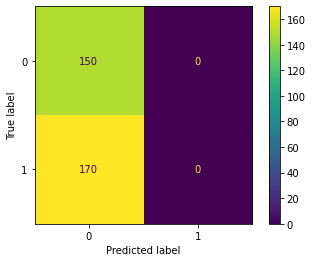

In [39]:
confustion_matrix(prediction_list_train,output_type="train")

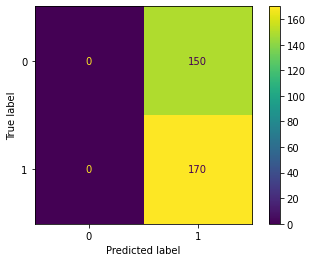

In [28]:
confustion_matrix(prediction_list_valid,output_type="valid")

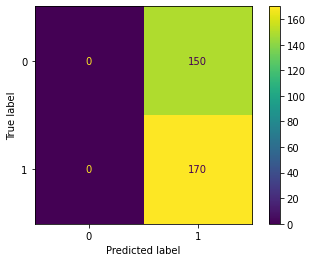

In [29]:
confustion_matrix(prediction_list_test,output_type="test")